# Analyzis of the Kickstarter Dataset

You can see the full project in our [github repositorium](https://github.com/MLobo1997/Kickstarter_predictor).

This dataset contains 378661 projects that occurred on the Kickstarter crowdfunding platform. There are 2 mains objective attributes for which we can be looking for within the data:

* The pledge a project obtains, which is something more interesting to observe from the point of view of Kickstarter itself, since they profit by commission.
* The final state of the projects, because a project can either achieve its pledge goal and succeed or it can fail.

Our goal with this study is to analyze which are the attributes which influence more both of these objectives. Obtaining a good predicting model would be impossible, given that the biggest key to success at Kickstarter are the introduction videos and the offers, which is information we do not contain in our dataset. Therefore, our main goal is to analyze inference of the attributes on our objectives.

## Loading the data

In [1]:
data <- read.csv("datasets/ks-projects-201801_WithOtherActive.csv",header=T,na.strings="?")
dim(data)

[1] 378661     16

## Analyzing the existing attributes

The `other_active_projects` was created by the team using a Java program that you can see in our [github repositorium](https://github.com/MLobo1997/Kickstarter_predictor). It contains the number of projects that were active at the the of launch of that project. We simply had a hunch it would be relevant

In [2]:
names(data)

[1] "ID"                    "name"                  "category"             
 [4] "main_category"         "currency"              "deadline"             
 [7] "goal"                  "launched"              "pledged"              
[10] "state"                 "backers"               "country"              
[13] "usd_pledged"           "usd_pledged_real"      "usd_goal_real"        
[16] "other_active_projects"

## Entry removal

Removing attributes which were not finished (at the time of the snapshot) yet or had wierd status.

In [3]:
data <- data[data$state %in% c("successful", "failed"),]
dim(data)

[1] 331675     16

## Column removal
Removing columns which shouldn't be used or do not tend to be useful
* `goal` because we have `usd_goal_real` which is all in the same currency.
* `pledge` and `usd_pledged` because we have `usd_pledged_real`.
* `state` because we don't want it for the `usd_pledged_real` regression and we can recreate it with the simple condition `usd_pledged_real > usd_goal_real`
* `backers` because that is part of the final result

In [4]:
projects <- data[,-c(7, 9, 10, 11, 13)]
names(projects)

[1] "ID"                    "name"                  "category"             
 [4] "main_category"         "currency"              "deadline"             
 [7] "launched"              "country"               "usd_pledged_real"     
[10] "usd_goal_real"         "other_active_projects"

### Transforming the factors into strings

In [5]:
projects$launched <- as.character(projects$launched)
projects$deadline <- as.character(projects$deadline)
projects$category <- as.character(projects$category)
projects$main_category <- as.character(projects$main_category)
projects$country <- as.character(projects$country)
projects$currency <- as.character(projects$currency)

## Now let's understand the attributes, one by one

### ID

In [6]:
length(unique(projects$ID))

[1] 331675

Most likely the ID won't be useful in any way.

## Name

In [7]:
length(unique(projects$name))

[1] 329595

Not useful as it is, but has potencial to extract other features, for example, the number of words in it:

### wordcount

In [8]:
projects$wordcount <- lengths(strsplit(as.character(projects$name), "\\W+"))
summary(projects$wordcount)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   3.000   5.000   5.653   8.000  27.000 

### Launched & Deadline

Sames as with name. Since the time of the year seemed only slightly relevant, we decided to not use it:

### month

In [9]:
projects$month <- substring(projects$launched, 6, 7)

In [10]:
projects$success <- projects$usd_pledged_real >= projects$usd_goal_real
tmp <- aggregate(success ~ month, data = projects, FUN = mean)

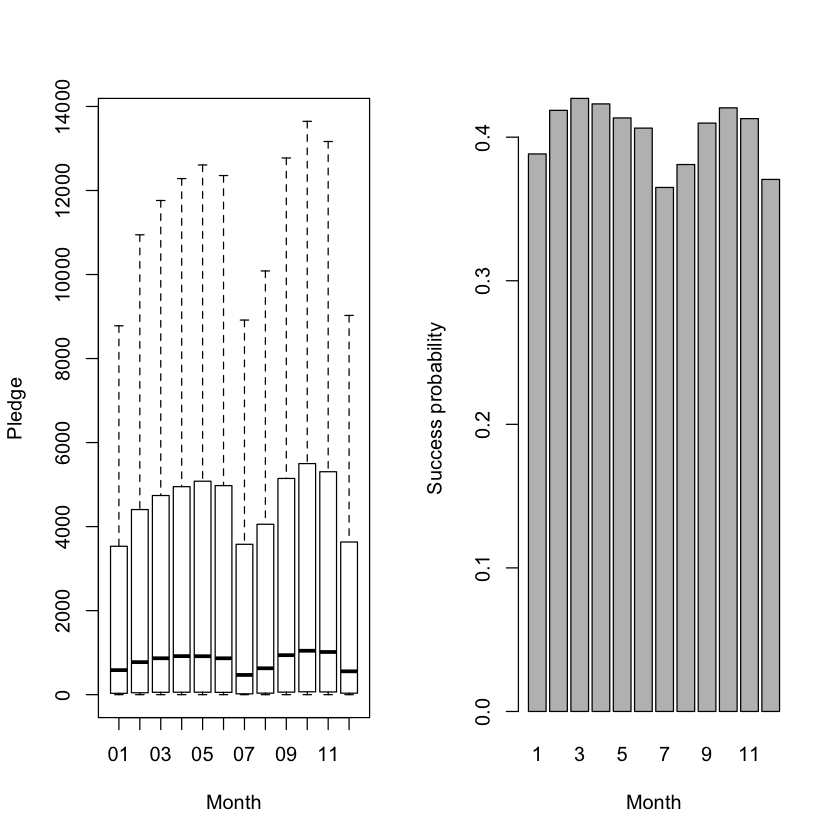

In [11]:
par(mfrow = c(1,2))
boxplot(projects$usd_pledged_real ~ projects$month, outline = F, xlab = "Month", ylab = "Pledge")
barplot(tmp$success, names.arg = 1:12, xlab = "Month", ylab = "Success probability")

Now let's check if the duration of the project can be important

### duration

In [12]:
projects$duration <- as.numeric(difftime(as.Date(projects[,"deadline"]), as.Date(projects[,"launched"])))
summary(projects$duration)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   30.00   30.00   33.95   36.00   92.00 

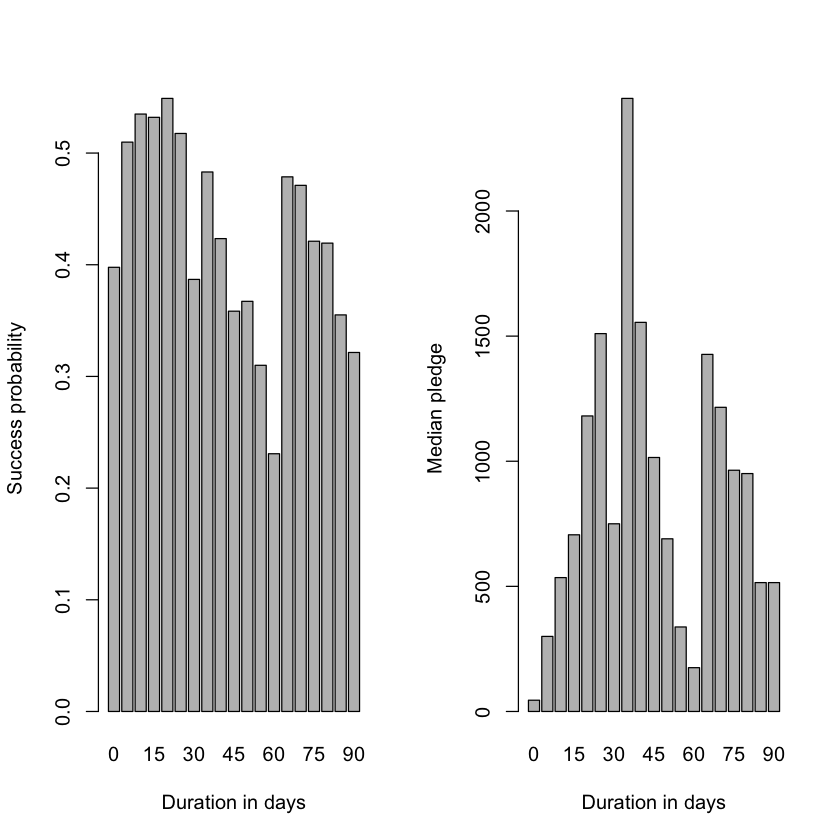

In [13]:
tmp <- aggregate(success ~ duration%/% 5, data = projects, FUN = mean)
par(mfrow = c(1,2))
barplot(tmp$success, names.arg = seq(0,90,5), xlab = "Duration in days", ylab = "Success probability")
tmp <- aggregate(usd_pledged_real ~ duration%/% 5, data = projects, FUN = median)
barplot(tmp$usd_pledged_real, names.arg = seq(0,90,5), xlab = "Duration in days", ylab = "Median pledge")

### Category & Main Category

In [14]:
unique(projects$main_category)

[1] "Publishing"   "Film & Video" "Music"        "Food"         "Crafts"      
 [6] "Games"        "Design"       "Comics"       "Fashion"      "Theater"     
[11] "Art"          "Photography"  "Technology"   "Dance"        "Journalism"

The high number of different values for this nominal attribute might be a problem.

In [15]:
length(unique(projects$category))

[1] 159

Besides, as we can observe here, there are only a few categories that exist in several main categories, that must be handled otherwise we will have redundat information.

In [16]:
tmp <- unique((projects[,c("category", "main_category")]))
dim(tmp)

[1] 170   2

In [17]:
library(plyr)
c <- count(tmp, 'category')
c[c$freq > 1,]

,category,freq
7,Anthologies,2
25,Comedy,4
45,Events,2
46,Experimental,2
54,Festivals,2
82,Letterpress,2
135,Spaces,3
152,Web,2


### categoryConcat
The problems noted before were simple to deal with. We just replaced the Category and the Main Category attributes with one that is the concatenation of both

In [18]:
projects$categoryConcat <- paste(projects$main_category, projects$category, sep = " - ")
projects <- projects[,-c(3,4)]
length(unique(projects$categoryConcat))

[1] 170

### Currency and Country
We realized the same happened with currency and country, therefore we decided to apply the same techique

In [19]:
projects$currencyCountry <- paste(as.character(projects$currency), as.character(projects$country), sep = "-")
length(unique(projects$currencyCountry))

[1] 30

#### Too many nominal values
Since the attributes `categoryConcat` and `currencyCountry` have too many diferent values (which is a problem for categorical columns) we decided to create a function that would transform them in numerical attributes. 

This functions sorts the categorical values by average pledge or success probability and then converts then converts those values into numerical ranks.

In [20]:
calculateEnumeratedCategoryValues <- function(dataset, category, objective){ 
  categories <- unique(category)
  v <- rep(0, length(categories))
  names(v) <- categories
  
  for(i in 1:length(v)){
    v[i] <- mean(dataset[category == categories[i], objective]) 
  }
  
  v <- sort(v)
  
  for (i in 1:length(v)){
    v[i] = i
  }
  
  return(v)
}

Another idea we had to fix this was by simply transforming the categorical values with minor pledge average or success rate into the same value ('Other')

In [21]:
filterBestCategories <- function(dataset, category, factorNr){
  v <- calculateCategoryValues(dataset, category) 
  
  bestCategories <- factor(names(tail(sort(v), factorNr))) 
  
  r <- rep("Other", dim(dataset)[1])
  for (i in 1:length(r)){
    if (category[i] %in% bestCategories){
      r[i] <- as.character(category[i])
    }
  }
  
  return(factor(r))
}

After some bruteforce testing we realized the ideal number of values to keep on the `categoryConcat` atribute would be 111. 

In [22]:
projects$categoryConcat2 <- filterBestCategories(projects, projects$categoryConcat, 111)
length(unique(projects$categoryConcat2))

[1] 112

And we also created the rank attributes. After doing some testing we realized that ranking was only good when making regression models for the pledge, therefore we didn't put the `success` attribute in this file.

In [23]:
projects$currencyCountryRank <- calculateEnumeratedCategoryValues(projects, projects$currencyCountry, "usd_pledged_real")[projects$currencyCountry]
summary(projects$currencyCountryRank)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   22.00   22.00   20.99   22.00   30.00 

In [24]:
projects$categoryConcatRank <- calculateEnumeratedCategoryValues(projects, projects$categoryConcat, "usd_pledged_real")[projects$categoryConcat]
summary(projects$categoryConcatRank)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   62.00  100.00   96.63  138.00  170.00 

### Other_active_projects
Now lets analyze the `other_active_projects` the attribute we added to our dataset with a java program.

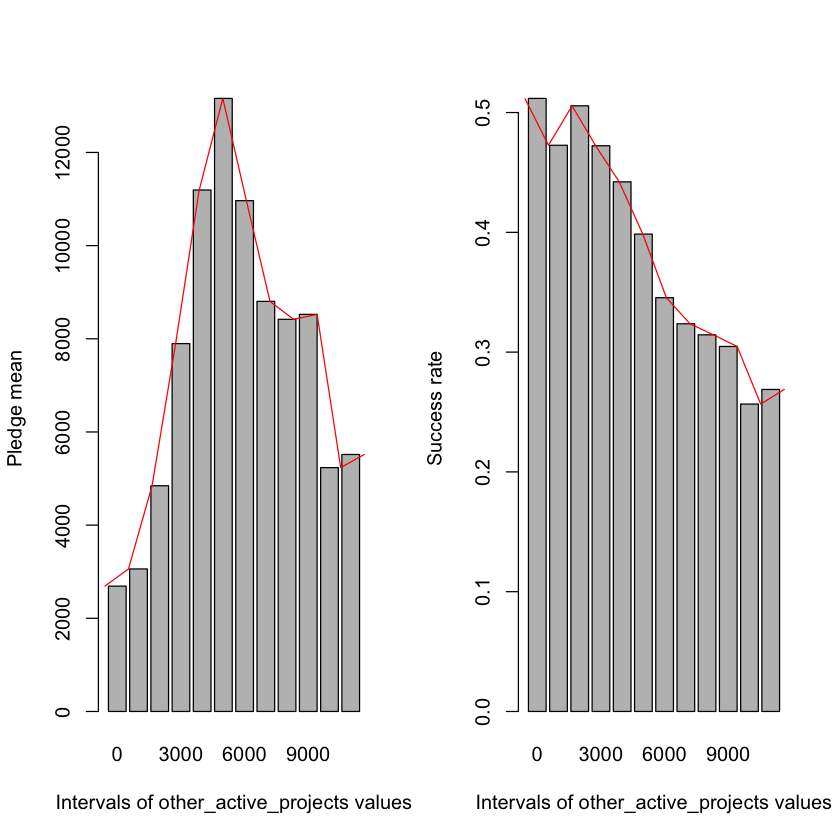

In [25]:
par(mfrow=c(1,2))
attach(projects)
pledge_by_other_actives <- aggregate(usd_pledged_real ~ (other_active_projects %/% 1000), FUN = mean)

barplot(pledge_by_other_actives$usd_pledged_real, width = 0.75, names.arg = pledge_by_other_actives$`other_active_projects%/%1000` * 1000, xlab = "Intervals of other_active_projects values", ylab = "Pledge mean")
lines(pledge_by_other_actives$`other_active_projects%/%1000`, pledge_by_other_actives$usd_pledged_real, col = "red")

pledge_by_other_actives <- aggregate(success ~ (other_active_projects %/% 1000), FUN = mean)

barplot(pledge_by_other_actives$success, width = 0.75, names.arg = pledge_by_other_actives$`other_active_projects%/%1000` * 1000, xlab = "Intervals of other_active_projects values", ylab = "Success rate")
lines(pledge_by_other_actives$`other_active_projects%/%1000`, pledge_by_other_actives$success, col = "red")
detach(projects)

As we can see, there is clear correlation. However this could be just caused by the growth of Kickstarter along the years. Let's see

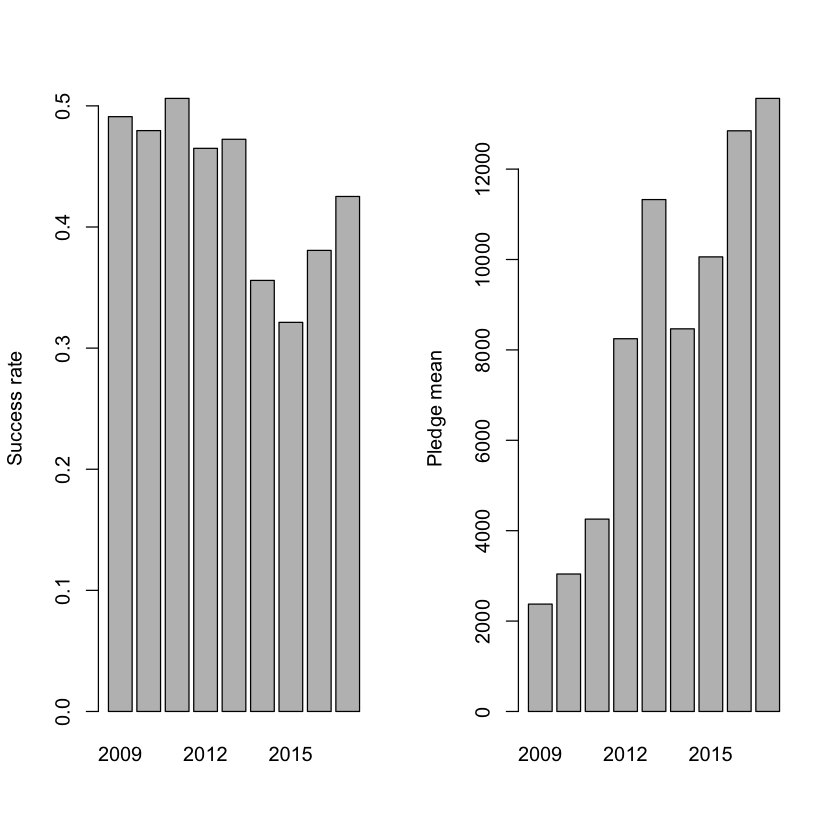

In [26]:
par(mfrow=c(1,2))
len_by_year <- aggregate(success ~ substring(launched,1,4), data = projects, FUN = mean)
barplot(len_by_year$success, names.arg = len_by_year$`substring(launched, 1, 4)`, ylab = "Success rate")

len_by_year <- aggregate(usd_pledged_real ~ substring(launched,1,4), data = projects, FUN = mean)
barplot(len_by_year$usd_pledged_real, names.arg = len_by_year$`substring(launched, 1, 4)`, ylab = "Pledge mean")

There's not a lot of similarity between these two plots and the ones above, therefore we can't take such conclusion.

Now, what are the attributes we have available?

In [27]:
names(projects)

[1] "ID"                    "name"                  "currency"             
 [4] "deadline"              "launched"              "country"              
 [7] "usd_pledged_real"      "usd_goal_real"         "other_active_projects"
[10] "wordcount"             "month"                 "success"              
[13] "duration"              "categoryConcat"        "currencyCountry"      
[16] "categoryConcat2"       "currencyCountryRank"   "categoryConcatRank"

In [28]:
projects <- projects[,-c(1,2,3,4,5,6)]
names(projects)

[1] "usd_pledged_real"      "usd_goal_real"         "other_active_projects"
 [4] "wordcount"             "month"                 "success"              
 [7] "duration"              "categoryConcat"        "currencyCountry"      
[10] "categoryConcat2"       "currencyCountryRank"   "categoryConcatRank"

## Train & Test data
Before creating models, we shuffle the data and split it in test and train data. The chosen attributes are the one we found as a best fit in regression of pledge (after some trial and error).

In [29]:
size <- dim(projects)[1]
set.seed(125)
indexes <- sample(1:dim(projects)[1], size)
set <- projects[indexes,]  

In [30]:
tmp   <-  set[, c("categoryConcatRank", "other_active_projects", "currencyCountryRank", "wordcount", "duration", "usd_goal_real", "usd_pledged_real", "month")]
train <-  tmp[1:(size%/%2),]
test  <-  tmp[(size%/%2):size,]
dim(train)
dim(test)

[1] 165837      8

[1] 165839      8

## Regression of pledge
We applied bruteforce on the power level of the polynomial attributes to find the ideal value for each, i.e: The one which minimizes the MAE (could also have used the Adjusted R-squared). We decided to use ***Mean Absolute Error*** because the vast number of outliers would result in a even more absurd ***Mean Squared Error***

In [31]:
lm.fit <- lm(usd_pledged_real~ poly(categoryConcatRank,2) + poly(usd_goal_real,12) + other_active_projects + currencyCountryRank + poly(duration, 18), data = train)
summary(lm.fit)
pred <- predict.lm(lm.fit, newdata = test, se.fit = T, interval = "prediction") 
mae <- mean((abs(pred$fit[,1] - test$usd_pledged_real)))
mae


Call:
lm(formula = usd_pledged_real ~ poly(categoryConcatRank, 2) + 
    poly(usd_goal_real, 12) + other_active_projects + currencyCountryRank + 
    poly(duration, 18), data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
 -274013   -10992    -2338     3175 12346666 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  -6.053e+02  1.751e+03  -0.346 0.729615    
poly(categoryConcatRank, 2)1  3.063e+06  8.414e+04  36.400  < 2e-16 ***
poly(categoryConcatRank, 2)2  2.309e+06  8.435e+04  27.375  < 2e-16 ***
poly(usd_goal_real, 12)1      1.617e+05  8.341e+04   1.938 0.052618 .  
poly(usd_goal_real, 12)2     -4.638e+05  8.344e+04  -5.558 2.73e-08 ***
poly(usd_goal_real, 12)3      6.729e+05  8.345e+04   8.064 7.46e-16 ***
poly(usd_goal_real, 12)4     -9.445e+05  8.346e+04 -11.317  < 2e-16 ***
poly(usd_goal_real, 12)5      8.935e+05  8.346e+04  10.706  < 2e-16 ***
poly(usd_goal_real, 12)6     -1.277e+06  8.354e+

[1] 15071.22

### Attribute evaluation

In [32]:
summary(lm.fit)$coef[,"Estimate"]

(Intercept) poly(categoryConcatRank, 2)1 
               -6.052573e+02                 3.062529e+06 
poly(categoryConcatRank, 2)2     poly(usd_goal_real, 12)1 
                2.309031e+06                 1.616610e+05 
    poly(usd_goal_real, 12)2     poly(usd_goal_real, 12)3 
               -4.637671e+05                 6.729407e+05 
    poly(usd_goal_real, 12)4     poly(usd_goal_real, 12)5 
               -9.444807e+05                 8.934575e+05 
    poly(usd_goal_real, 12)6     poly(usd_goal_real, 12)7 
               -1.276615e+06                 1.186432e+06 
    poly(usd_goal_real, 12)8     poly(usd_goal_real, 12)9 
               -1.514253e+06                 1.178594e+06 
   poly(usd_goal_real, 12)10    poly(usd_goal_real, 12)11 
               -1.090766e+06                 1.172838e+06 
   poly(usd_goal_real, 12)12        other_active_projects 
               -1.068982e+06                -3.574410e-01 
         currencyCountryRank          poly(duration, 18)1 
                5.923605e+02                -1.074821e+05 
         poly(duration, 18)2          poly(duration, 18)3 
               -5.843831e+05                 1.863258e+05 
         poly(duration, 18)4          poly(duration, 18)5 
                6.113866e+05                 2.212637e+05 
         poly(duration, 18)6          poly(duration, 18)7 
               -4.178616e+05                -8.548326e+04 
         poly(duration, 18)8          poly(duration, 18)9 
                3.129492e+05                -9.371743e+04 
        poly(duration, 18)10         poly(duration, 18)11 
               -1.870432e+05                 2.450415e+05 
        poly(duration, 18)12         poly(duration, 18)13 
               -1.109362e+05                -2.003725e+05 
        poly(duration, 18)14         poly(duration, 18)15 
                2.931158e+05                 4.635352e+04 
        poly(duration, 18)16         poly(duration, 18)17 
               -2.766581e+05                 1.108322e+05 
        poly(duration, 18)18 
                2.184230e+05

In [33]:
eq <- function(x, coefs, intercept){
    n <- length(coefs)
    r <- intercept 
    
    cat("Power level:", n)
    
    for (i in 1:n){
        r = r + coefs[i] * x^i
    }
    return(r)
}

#### CategoryConcat

Power level: 2

Crafts - Crochet     Crafts - Candles  Crafts - Embroidery 
                   1                    2                    3 
Photography - Places    Crafts - Printing         Crafts - DIY 
                   4                    5                    6

Technology - Fabrication Tools        Games - Gaming Hardware 
                           165                            166 
        Technology - Wearables             Technology - Sound 
                           167                            168 
      Technology - 3D Printing  Technology - Camera Equipment 
                           169                            170

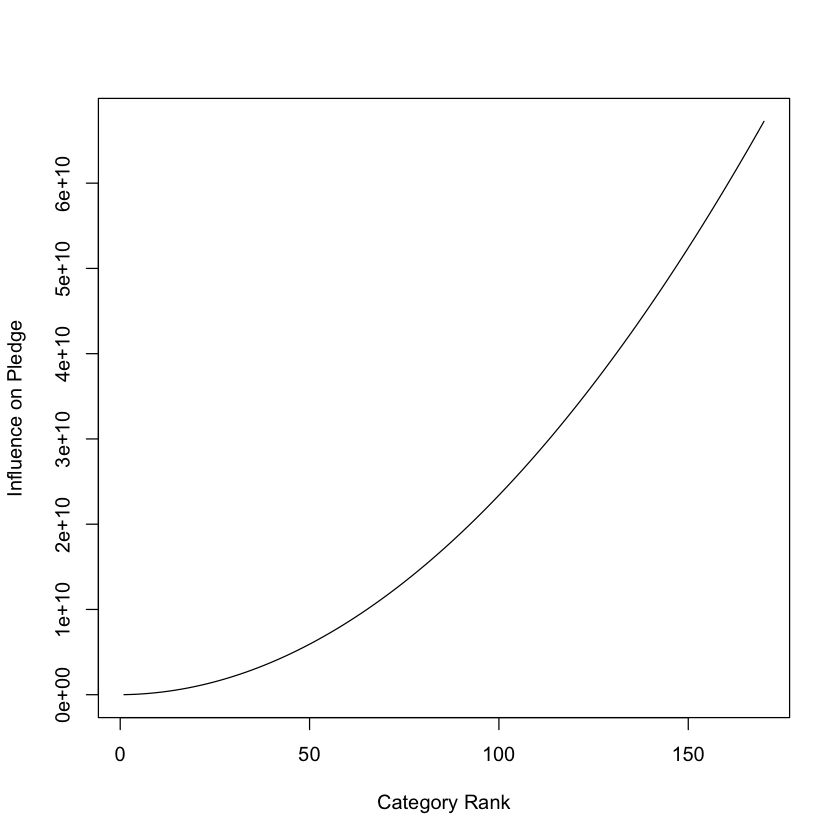

In [34]:
coefs <- summary(lm.fit)$coef[2:3,"Estimate"]
curve(eq(x, coefs, 0), xlab = "Category Rank", ylab = "Influence on Pledge", from = 1, to = 170)

tmp <- calculateEnumeratedCategoryValues(projects, projects$categoryConcat, "usd_pledged_real")
head(tmp)
tail(tmp)

In [35]:
summary(projects$usd_goal_real)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
        0      2000      5000     41510     15000 166361391 

Power level: 12

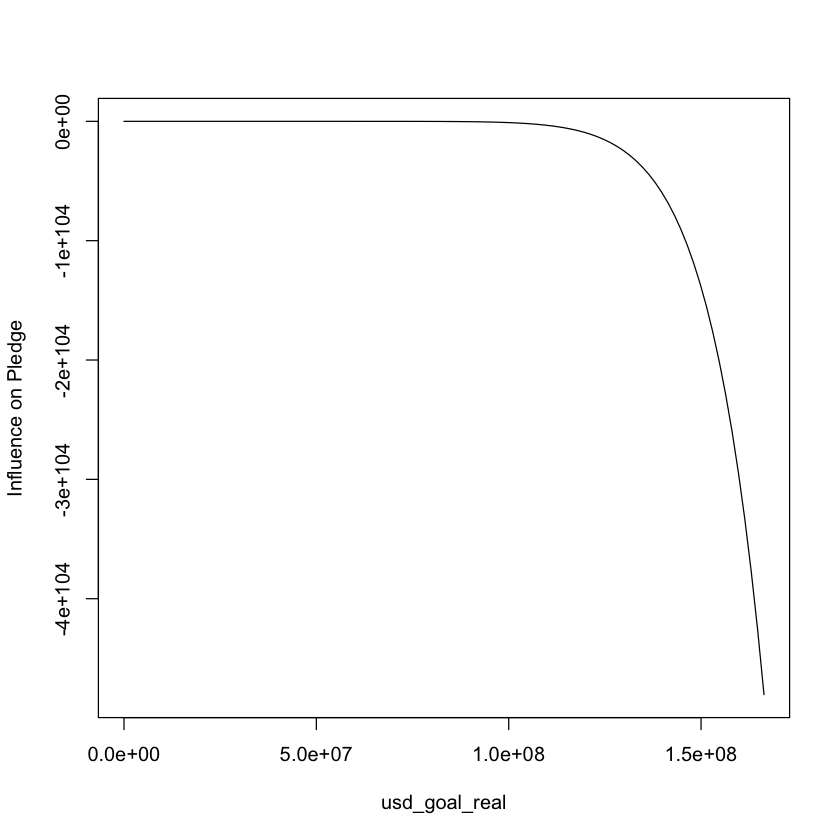

In [36]:
coefs <- summary(lm.fit)$coef[4:15,"Estimate"]
curve(eq(x, coefs, 0), xlab = "usd_goal_real", ylab = "Influence on Pledge", from = 1, to = 166361391)

#### Other_active_projects

In [37]:
summary(projects$other_active_projects)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      8    4193    4994    5404    6602   11654 

Power level: 1

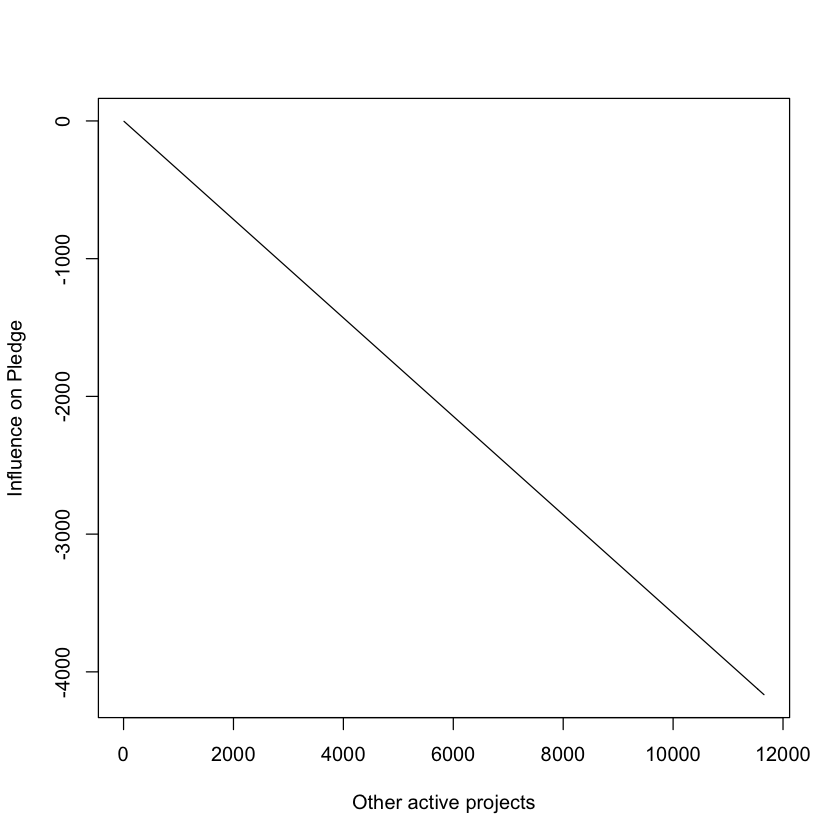

In [38]:
coefs <- summary(lm.fit)$coef[16,"Estimate"]
curve(eq(x, coefs, 0), xlab = "Other active projects", ylab = "Influence on Pledge", from = 8, to = 11654)

#### Duration

In [39]:
summary(projects$duration)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   30.00   30.00   33.95   36.00   92.00 

Power level: 18

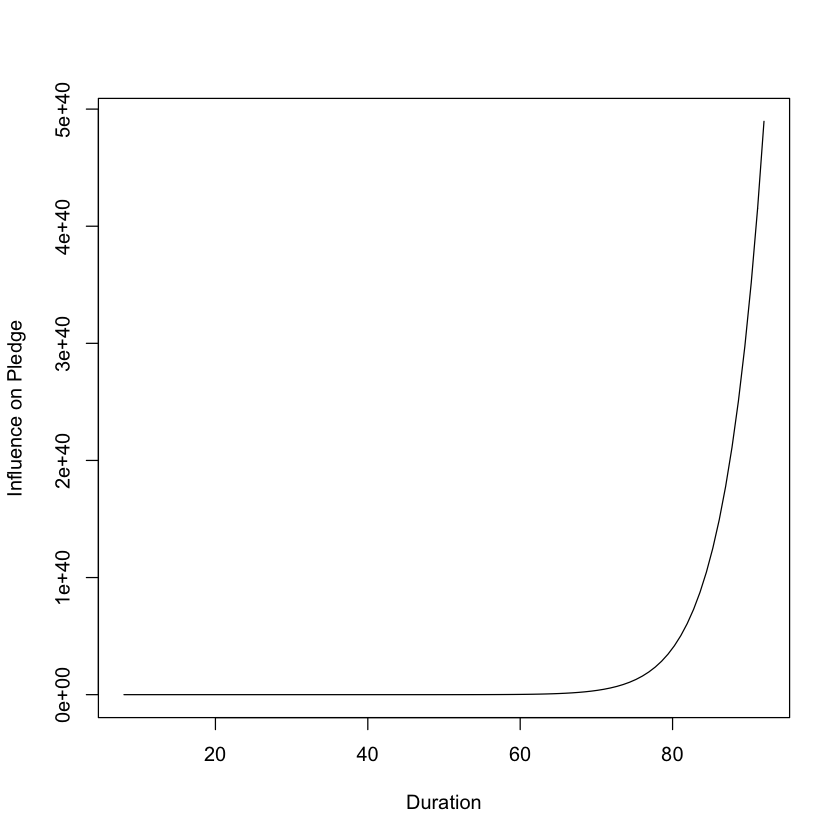

In [40]:
coefs <- summary(lm.fit)$coef[18:35,"Estimate"]
curve(eq(x, coefs, 0), xlab = "Duration", ylab = "Influence on Pledge", from = 8, to = 92)

These plots should allow us to take some conclusions such as:

* A bigger goal will result in a smaller pledge.
* The more active projects, the smaller is the average pledge.
* Increased duration means bigger pledge.

Of course, these conclusions might look odd, but some of this plots might not be very accurate given that the *Adjusted-R squared* of the model is only 2%, which model only describes 2% of the information in the data.

## Success prediction
Now let's evaluate what are the best conditions for a project to achieve its goal.

In [41]:
tmp   <-  set[, c("categoryConcat2", "other_active_projects", "currencyCountry", "wordcount", "duration", "usd_goal_real", "success")]
train <-  tmp[1:(size%/%2),]
test  <-  tmp[(size%/%2):size,]
dim(train)
dim(test)

[1] 165837      7

[1] 165839      7

This entry was causing some trouble so we just removed it

In [42]:
test <- test[test$currencyCountry != 'SEK-N,0\"',]
dim(test)

[1] 165838      7

In [43]:
glm.fit <- glm(success ~ categoryConcat2 + poly(usd_goal_real,10) + poly(other_active_projects, 7) + currencyCountry + poly(wordcount, 15) + poly(duration, 18), data = train)
pred <- ((predict.glm(glm.fit, newdata = test, type = "response")) > 0.5)
table(pred, test$success)
accuracy <- mean(test$success == pred)
accuracy

       
pred    FALSE  TRUE
  FALSE 80260 35936
  TRUE  18616 31026

[1] 0.6710525

In [59]:
freqs <- table(projects$success)
freqs / length(projects$success) 


    FALSE      TRUE 
0.5961197 0.4038803 

Given that the success/failure rate is approximately 60%/40% and that our model has an accuracy of 67%, it means we obtain an AUC (Area Under Curve) superior to 0.5, but not much.

### Let's evaluate the influence of each attribute again.
#### usd_goal_real

In [68]:
summary(projects$usd_goal_real)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
        0      2000      5000     41510     15000 166361391 

Power level: 10

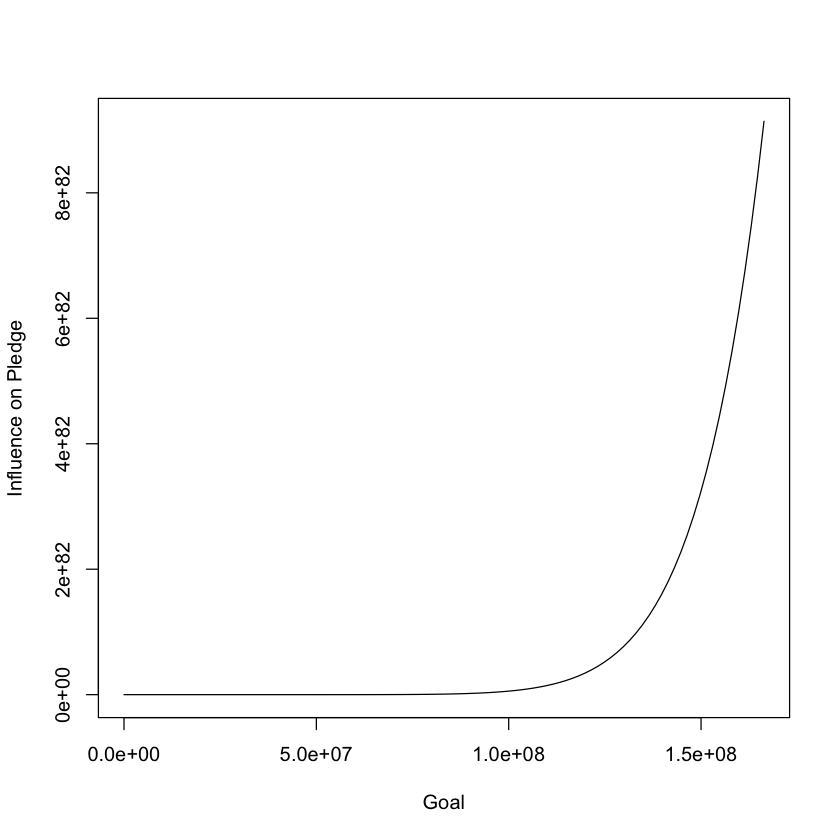

In [69]:
library(stringr)
coefs <- summary(glm.fit)$coefficients[,"Estimate"]
idx <- str_detect(names(coefs), "usd_goal_real")
curve(eq(x, coefs[idx], 0), xlab = "Goal", ylab = "Influence on Pledge", from = 0, to = 166361391)

#### other_active_projects

In [73]:
summary(projects$other_active_projects)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      8    4193    4994    5404    6602   11654 

poly(other_active_projects, 7)1 poly(other_active_projects, 7)2 
                    -15.7744632                      -0.9299844 
poly(other_active_projects, 7)3 poly(other_active_projects, 7)4 
                      1.7119827                       0.2926313 
poly(other_active_projects, 7)5 poly(other_active_projects, 7)6 
                     -2.0871281                       1.2359274 
poly(other_active_projects, 7)7 
                      0.2328454

Power level: 7

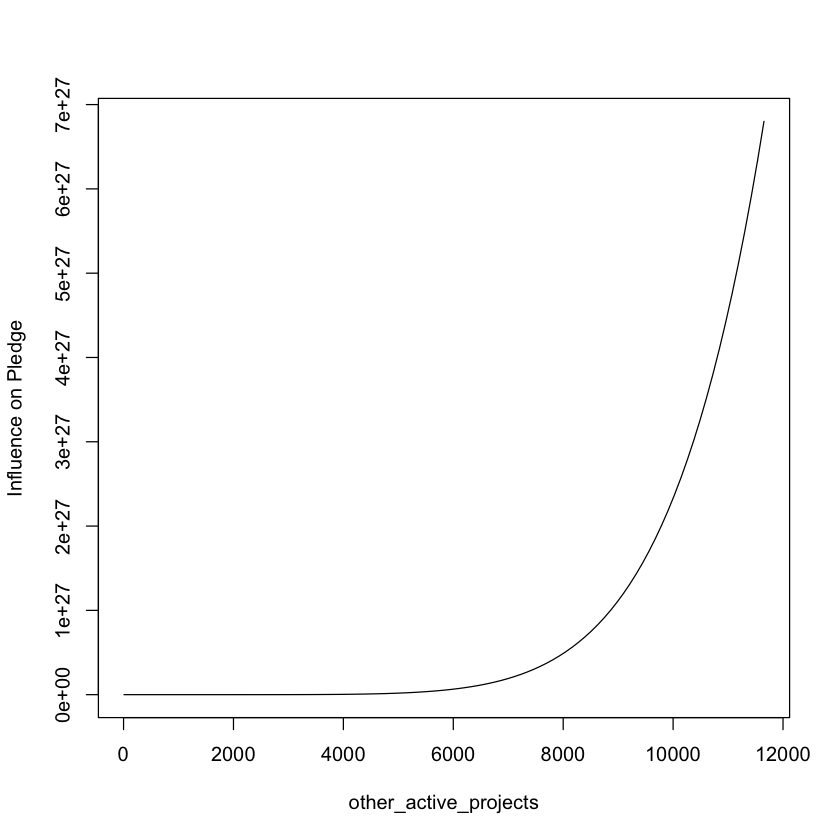

In [74]:
idx <- str_detect(names(coefs), "other_active_projects")
curve(eq(x, coefs[idx], 0), xlab = "other_active_projects", ylab = "Influence on Pledge", from = 8, to = 11654)

#### wordcount

In [76]:
summary(projects$wordcount)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   3.000   5.000   5.653   8.000  27.000 

Power level: 15

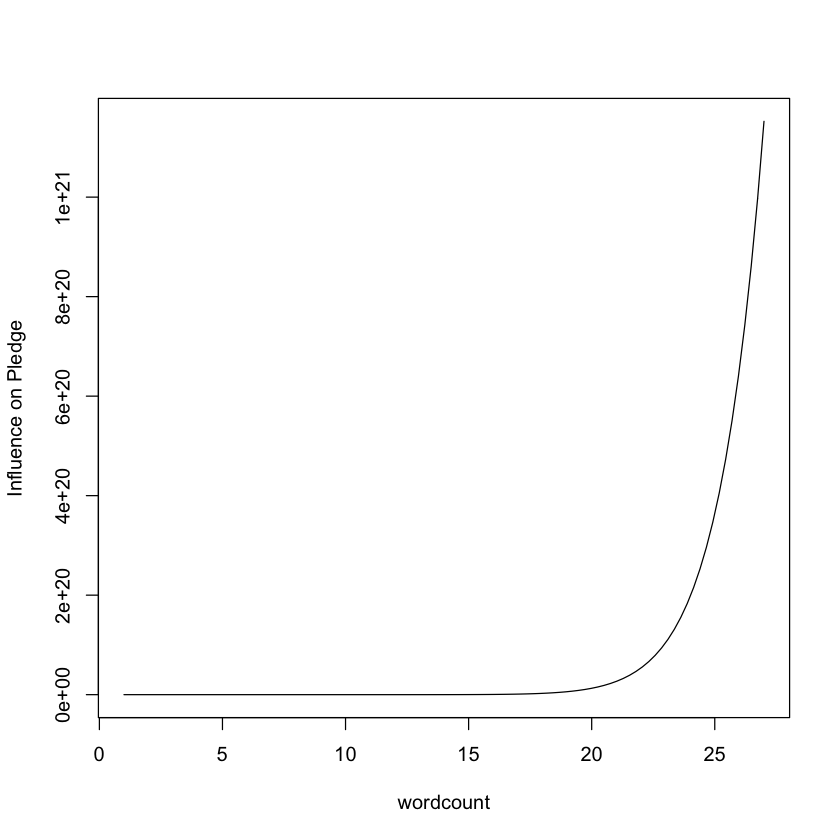

In [78]:
idx <- str_detect(names(coefs), "wordcount")
curve(eq(x, coefs[idx], 0), xlab = "wordcount", ylab = "Influence on Pledge", from = 1, to = 27)

#### duration

In [79]:
summary(projects$duration)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   30.00   30.00   33.95   36.00   92.00 

Power level: 18

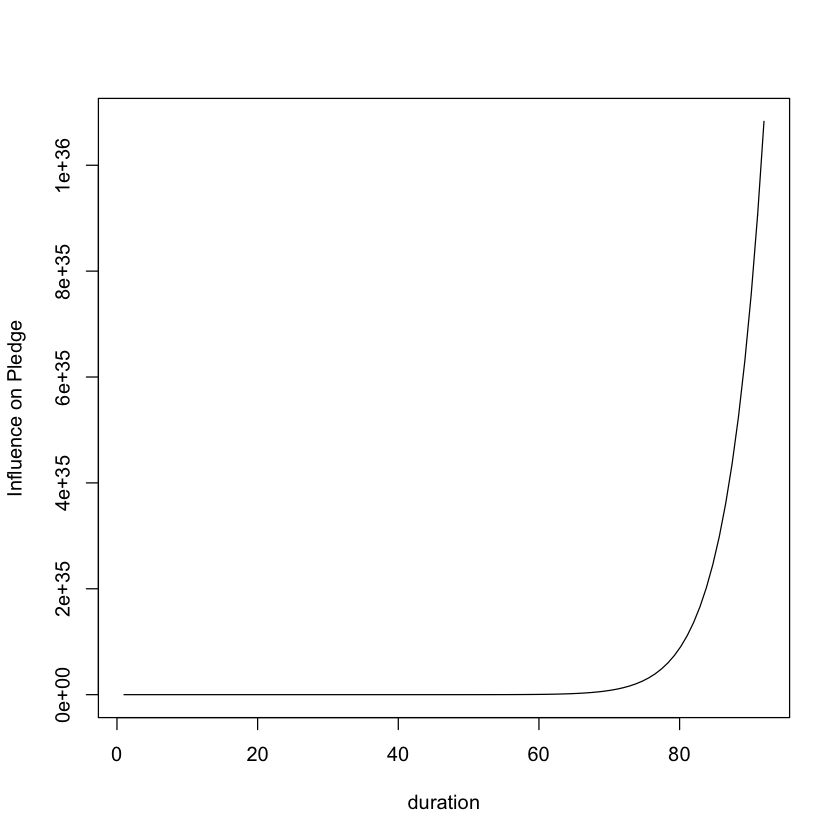

In [80]:
idx <- str_detect(names(coefs), "duration")
curve(eq(x, coefs[idx], 0), xlab = "duration", ylab = "Influence on Pledge", from = 1, to = 92)